# 2. Preprocessing
## 2.05 Preparing the data for the models

To avoid preprocessing the raw input data every time before running a model, we prepare the dataset in this notebook using the insights gained from the previous steps.

### Curse of dimensionality
There is one issue that you encounter when dealing with geospatial data: Basically you would want to use all the data you can get in order to achieve the best results with your model, but geospatial data with probably high spatial correlation introduces problems like overfitting the model on one predictor variable and destabilizes the resulting prediction model.

To roughly estimate the input space dimensionality, imagine using all ERA5 gridpoints of the upstream area of one point. For a 1.5x1.5 degree (lat,lon) grid, ERA5 provides 6 x 6 gridpoints. To take the time dimension into account we'd need about 180 days of precipitation, which sums to 6480 features. Compare that to a 20 year daily timeseries (~7300 samples), which clearly violates the rule of thumb of 10 features per sample and inhibits learning from data.

To work around that, we need to reduce the dimensionality by
- spatially aggregating and
- temporally aggregating the data

Both will be done in sections below.

In [1]:
import numpy as np
import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import sys
sys.path.append('../../')
from python.aux.utils_floodmodel import get_mask_of_basin, add_shifted_variables, reshape_scalar_predictand, shift_and_aggregate

In [2]:
# load data
era5 = xr.open_mfdataset('../../data/sampledata-*-era5.nc', combine='by_coords')
glofas = xr.open_mfdataset('../../data/sampledata-*-glofas.nc', combine='by_coords')

First of all, reduce the data spatially to the basin, interpolate era5 data onto the glofas grid and for the 2013 sample data, limit the relevant range (as determined from the general flow direction, eastward, and the approximate range of significant relevance from the spatial correlations).

In [3]:
danube_catchment = get_mask_of_basin(glofas['dis'].isel(time=0))
dis = glofas['dis'].where(danube_catchment)

In [4]:
era5_basin = era5.interp(latitude=glofas.latitude,
                         longitude=glofas.longitude).where(danube_catchment)

Check if the spatial domain looks good.

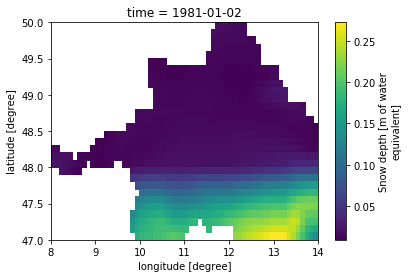

In [5]:
era5_basin['sd'].isel(time=1).plot()

Add the change in snow depth as additional variable.

In [6]:
sd_diff = era5_basin['sd'].diff(dim='time')
sd_diff.name = 'sd_diff'
era5_basin = era5_basin.assign({'sd_diff': sd_diff})

In [7]:
era5_basin

<xarray.Dataset>
Dimensions:      (latitude: 30, longitude: 60, time: 13514)
Coordinates:
  * time         (time) datetime64[ns] 1981-01-01 1981-01-02 ... 2017-12-31
  * latitude     (latitude) float64 49.95 49.85 49.75 ... 47.25 47.15 47.05
  * longitude    (longitude) float64 8.05 8.15 8.25 8.35 ... 13.75 13.85 13.95
Data variables:
    cp           (time, latitude, longitude) float32 dask.array<shape=(13514, 30, 60), chunksize=(7305, 30, 60)>
    lsp          (time, latitude, longitude) float32 dask.array<shape=(13514, 30, 60), chunksize=(7305, 30, 60)>
    swvl1        (time, latitude, longitude) float32 dask.array<shape=(13514, 30, 60), chunksize=(7305, 30, 60)>
    tcwv         (time, latitude, longitude) float32 dask.array<shape=(13514, 30, 60), chunksize=(7305, 30, 60)>
    ro           (time, latitude, longitude) float32 dask.array<shape=(13514, 30, 60), chunksize=(7305, 30, 60)>
    sd           (time, latitude, longitude) float32 dask.array<shape=(13514, 30, 60), chunksize=(

Average the features in the basin.

In [8]:
# average features in the basin
era5_basin = era5_basin.mean(['latitude', 'longitude'])

Add long-time large-scale precipitation as feature (memory effect).

In [9]:
era5_basin['lsp-4-11'] = shift_and_aggregate(era5_basin['lsp'], shift=4, aggregate=8)
era5_basin['lsp-12-25'] = shift_and_aggregate(era5_basin['lsp'], shift=12, aggregate=14)
era5_basin['lsp-26-55'] = shift_and_aggregate(era5_basin['lsp'], shift=26, aggregate=30)
era5_basin['lsp-56-180'] = shift_and_aggregate(era5_basin['lsp'], shift=56, aggregate=125)

In [10]:
era5_basin

<xarray.Dataset>
Dimensions:      (time: 13514)
Coordinates:
  * time         (time) datetime64[ns] 1981-01-01 1981-01-02 ... 2017-12-31
Data variables:
    cp           (time) float32 dask.array<shape=(13514,), chunksize=(7305,)>
    lsp          (time) float32 dask.array<shape=(13514,), chunksize=(7305,)>
    swvl1        (time) float32 dask.array<shape=(13514,), chunksize=(7305,)>
    tcwv         (time) float32 dask.array<shape=(13514,), chunksize=(7305,)>
    ro           (time) float32 dask.array<shape=(13514,), chunksize=(7305,)>
    sd           (time) float32 dask.array<shape=(13514,), chunksize=(7305,)>
    rtp_500-850  (time) float32 dask.array<shape=(13514,), chunksize=(7305,)>
    sd_diff      (time) float32 dask.array<shape=(13514,), chunksize=(7305,)>
    lsp-4-11     (time) float32 dask.array<shape=(13514,), chunksize=(4,)>
    lsp-12-25    (time) float32 dask.array<shape=(13514,), chunksize=(7,)>
    lsp-26-55    (time) float32 dask.array<shape=(13514,), chunksize=(15,

### Prepare the feature array X and predictand y
For easier use, let's define the preparation routine here.

In [11]:
def prepare_features(x, y, point=None):
    # drop the features which did show no impact in the feature selection
    x = x.drop('tcwv')
    x = x.drop('rtp_500-850')
    #features = ['cp', 'lsp', 'ro', 'swvl1', 'sd', 'sd_diff']
    #x = x[features]
        
    for var in ['lsp', 'cp']:
        for i in range(1,4):
            newvar = var+'-'+str(i)
            x[newvar] = x[var].shift(time=i)  # previous precip as current day variable

    # select the point of interest
    if not point:
        poi = dict(latitude=48.35, longitude=13.95)  # point in upper austria
    elif point == 'krems':
        poi = dict(latitude=48.35, longitude=15.65)  # krems (lower austria), outside the test dataset
    
    # select area of interest and average over space for all features
    y_poi = y.interp(poi)
    y_poi_diff = y_poi.diff('time', 1)  # compare predictors to change in discharge
    y_poi_diff.name = 'dis_diff'

    # merge into one dataset
    sample_data = xr.merge([x, y_poi, y_poi_diff])
    sample_data = sample_data.drop(['latitude', 'longitude'])
    return sample_data
sample_data_1 = prepare_features(era5_basin, dis)

Visual check on the prepared data.

/home/srvx11/lehre/users/a1303583/.conda/envs/ml_flood/lib/python3.7/site-packages/dask/array/numpy_compat.py:38: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/srvx11/lehre/users/a1303583/.conda/envs/ml_flood/lib/python3.7/site-packages/dask/array/numpy_compat.py:38: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/srvx11/lehre/users/a1303583/.conda/envs/ml_flood/lib/python3.7/site-packages/dask/array/numpy_compat.py:38: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/srvx11/lehre/users/a1303583/.conda/envs/ml_flood/lib/python3.7/site-packages/dask/array/numpy_compat.py:38: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


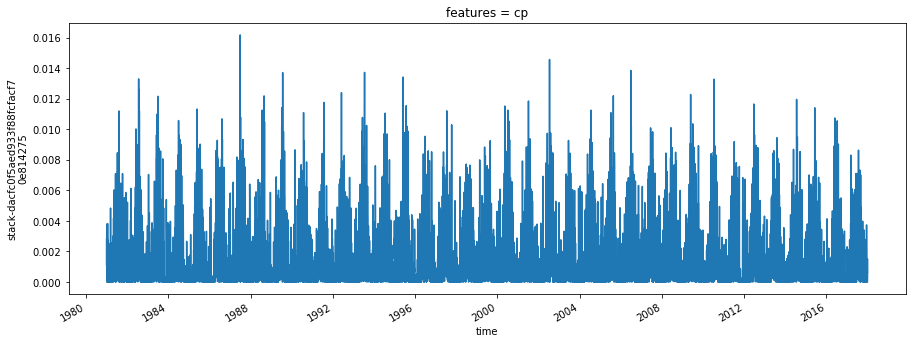

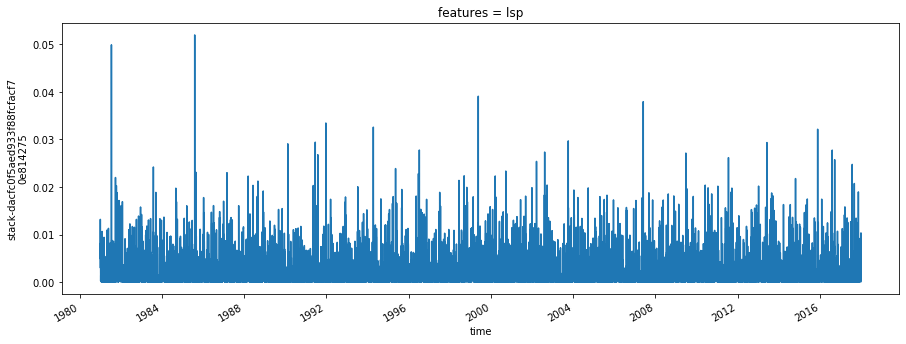

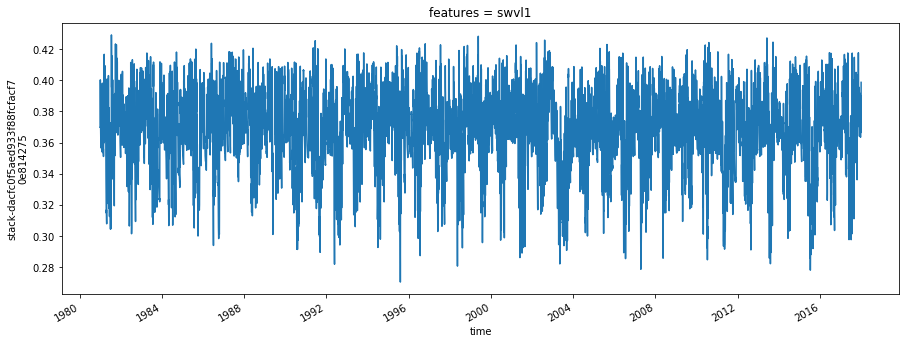

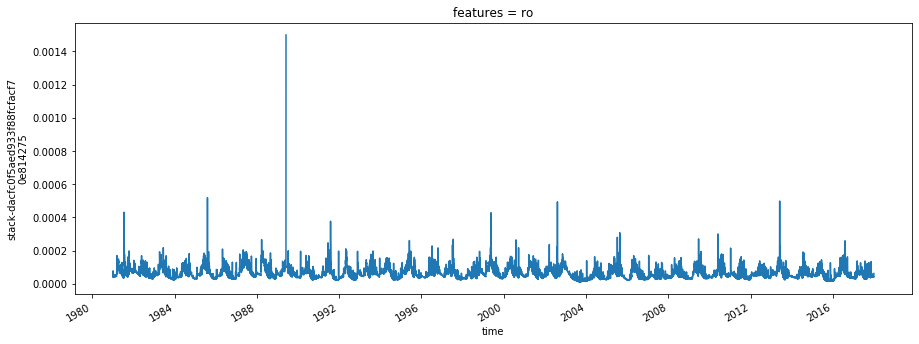

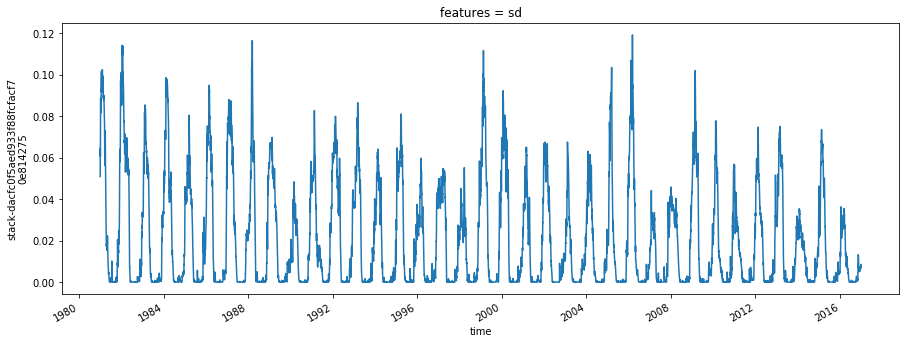

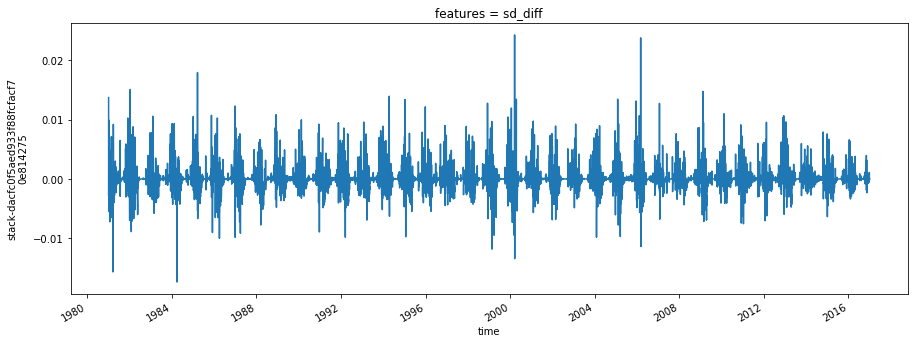

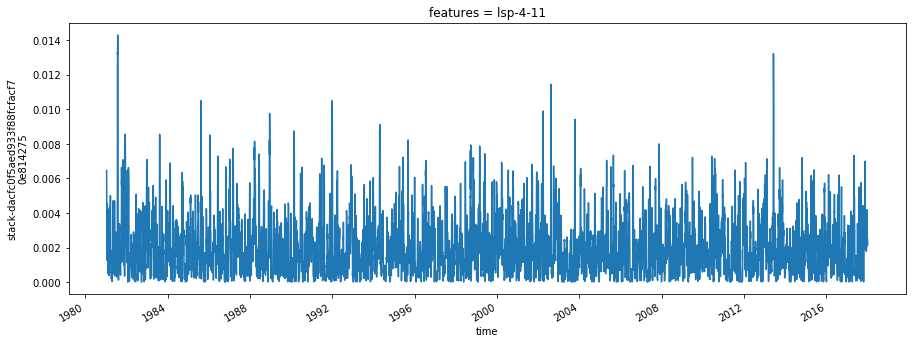

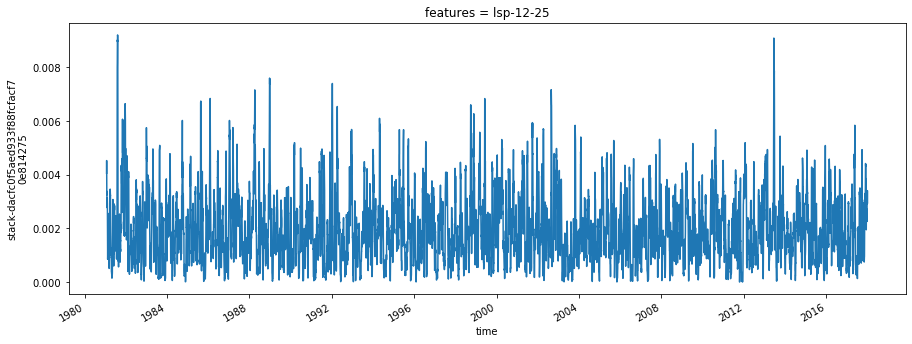

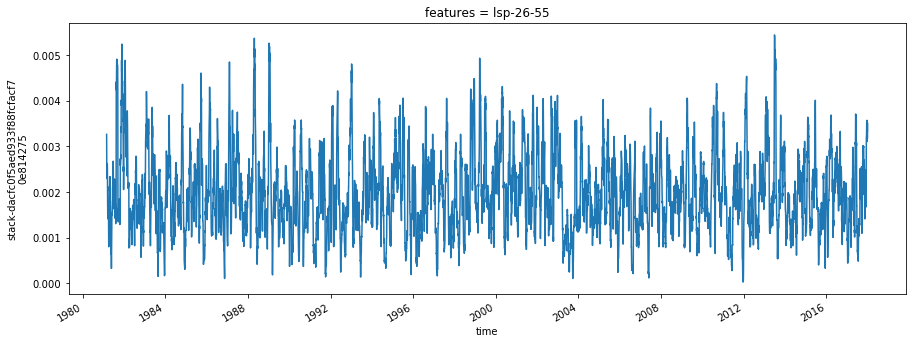

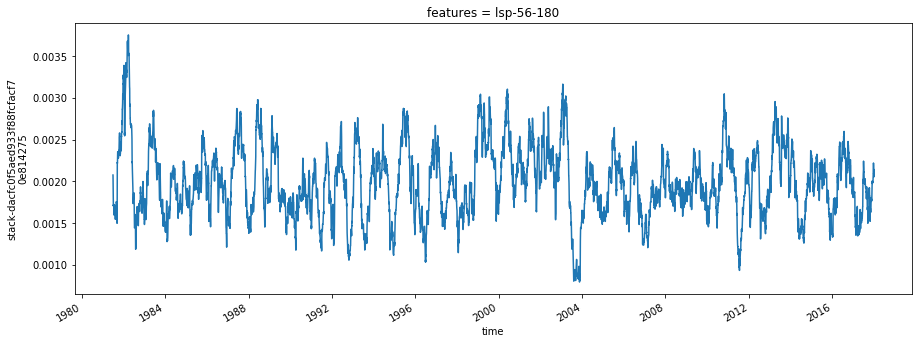

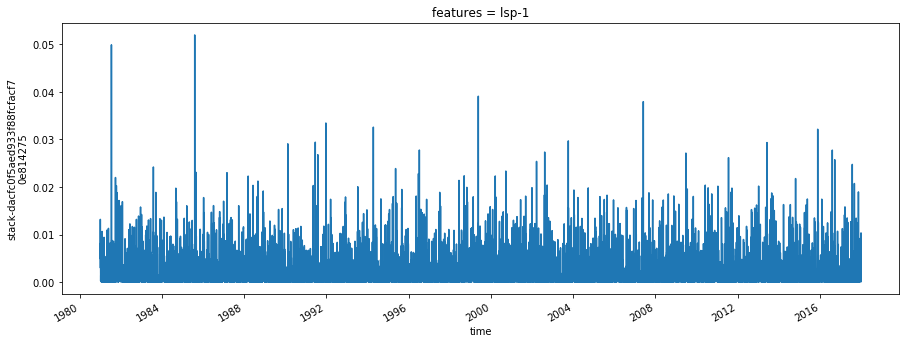

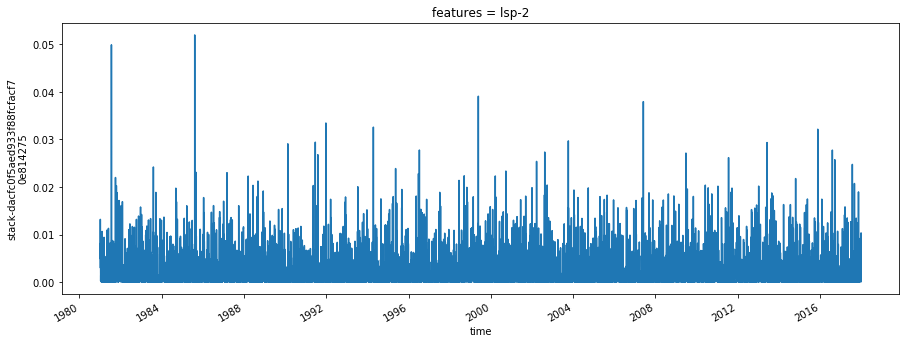

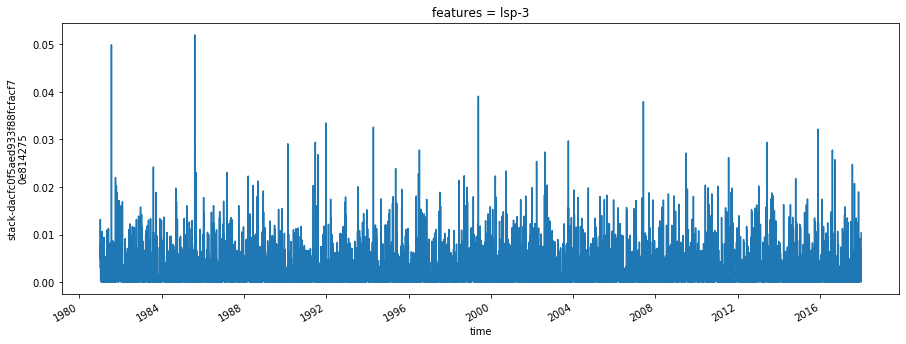

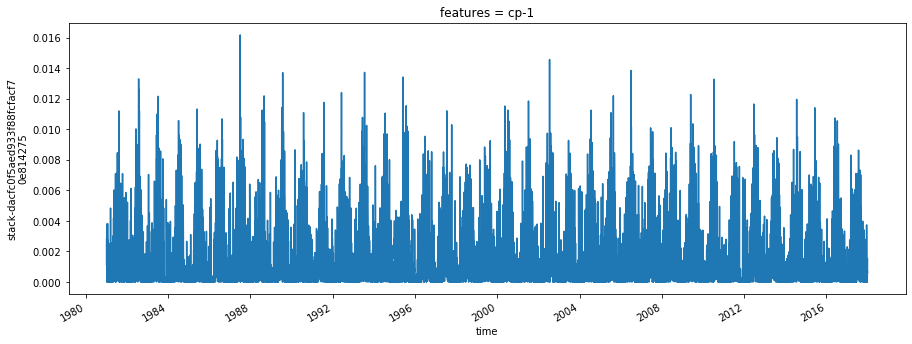

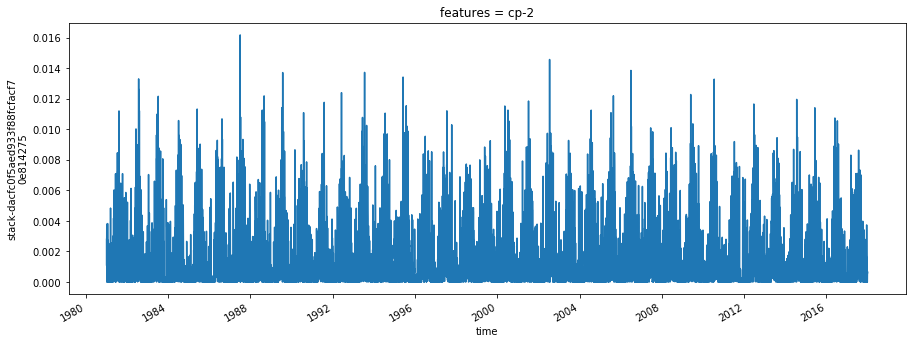

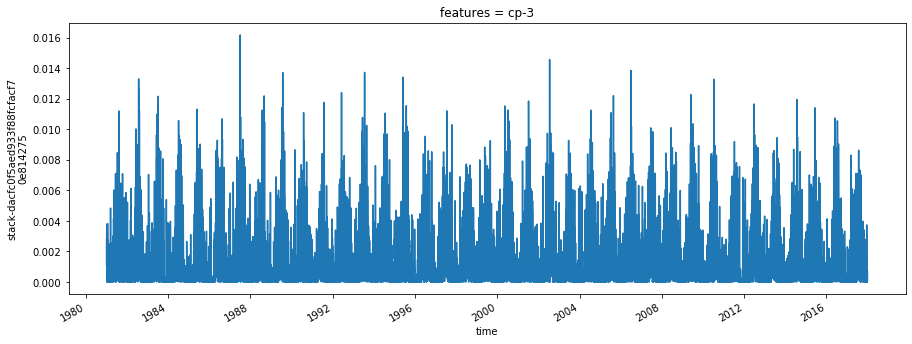

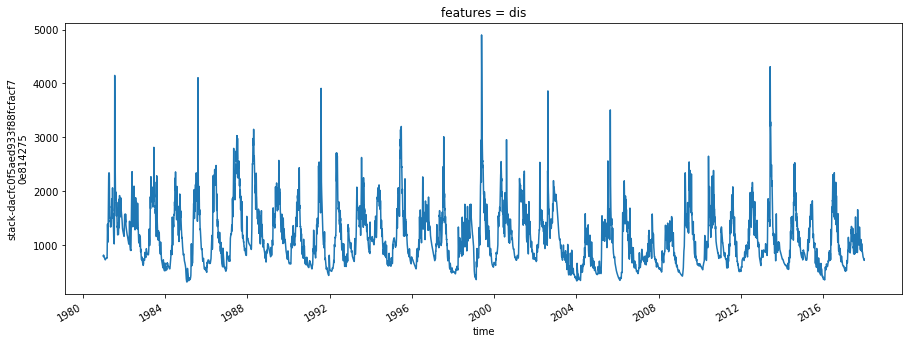

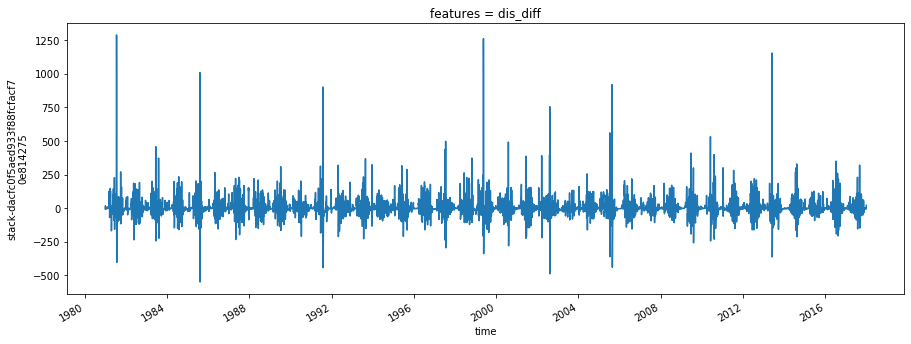

In [12]:
test1 = sample_data_1.to_array(dim='features').T
for f in test1.features:
    plt.figure(figsize=(15,5))
    test1.sel(features=f).plot(ax=plt.gca())

Correct the `ro` outlier as nanmean from the two values next to it.

In [14]:
sample_data_1.load()

/home/srvx11/lehre/users/a1303583/.conda/envs/ml_flood/lib/python3.7/site-packages/dask/array/numpy_compat.py:38: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


<xarray.Dataset>
Dimensions:     (time: 13514)
Coordinates:
  * time        (time) datetime64[ns] 1981-01-01 1981-01-02 ... 2017-12-31
Data variables:
    cp          (time) float32 0.0027969202 0.0010736011 ... 6.3911815e-05
    lsp         (time) float32 0.0030839704 0.01112505 ... 0.0028783886
    swvl1       (time) float32 0.36975124 0.36971572 ... 0.37917453 0.3986332
    ro          (time) float32 4.0711366e-05 4.0798546e-05 ... 6.1603096e-05
    sd          (time) float32 0.050891068 0.06464155 0.061856583 ... nan nan
    sd_diff     (time) float32 nan 0.013750497 -0.0027849725 ... nan nan nan
    lsp-4-11    (time) float32 nan nan nan ... 0.0021004332 0.0024646148
    lsp-12-25   (time) float32 nan nan nan ... 0.003055691 0.00295202
    lsp-26-55   (time) float32 nan nan nan ... 0.003511974 0.0031857586
    lsp-56-180  (time) float32 nan nan nan ... 0.0020519472 0.0021398212
    lsp-1       (time) float32 nan 0.0030839704 ... 0.0012526653 0.006716862
    lsp-2       (time) floa

In [15]:
amax_ind = np.argmax(test1.sel(features='ro').values)-1
print(sample_data_1['ro'][amax_ind])
sample_data_1['ro'][amax_ind] = np.nanmean([sample_data_1['ro'][amax_ind-1], sample_data_1['ro'][amax_ind+1]])
print(sample_data_1['ro'][amax_ind])

<xarray.DataArray 'ro' ()>
array(0.0015, dtype=float32)
Coordinates:
    time     datetime64[ns] 1989-06-01
<xarray.DataArray 'ro' ()>
array(0.000105, dtype=float32)
Coordinates:
    time     datetime64[ns] 1989-06-01


/home/srvx11/lehre/users/a1303583/.conda/envs/ml_flood/lib/python3.7/site-packages/dask/array/numpy_compat.py:38: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


Save preprocessed features as .nc files.

In [16]:
sample_data_1

<xarray.Dataset>
Dimensions:     (time: 13514)
Coordinates:
  * time        (time) datetime64[ns] 1981-01-01 1981-01-02 ... 2017-12-31
Data variables:
    cp          (time) float32 0.0027969202 0.0010736011 ... 6.3911815e-05
    lsp         (time) float32 0.0030839704 0.01112505 ... 0.0028783886
    swvl1       (time) float32 0.36975124 0.36971572 ... 0.37917453 0.3986332
    ro          (time) float32 4.0711366e-05 4.0798546e-05 ... 6.1603096e-05
    sd          (time) float32 0.050891068 0.06464155 0.061856583 ... nan nan
    sd_diff     (time) float32 nan 0.013750497 -0.0027849725 ... nan nan nan
    lsp-4-11    (time) float32 nan nan nan ... 0.0021004332 0.0024646148
    lsp-12-25   (time) float32 nan nan nan ... 0.003055691 0.00295202
    lsp-26-55   (time) float32 nan nan nan ... 0.003511974 0.0031857586
    lsp-56-180  (time) float32 nan nan nan ... 0.0020519472 0.0021398212
    lsp-1       (time) float32 nan 0.0030839704 ... 0.0012526653 0.006716862
    lsp-2       (time) floa

In [ ]:
sample_data_1.to_netcdf('../../data/features_xy.nc')

In [ ]:
sample_data_1['dis'].sel(time=slice('2013-5', '2013-6')).plot()